# Classifier performance

Let's return to the (cleaned) loan applications dataset.

In [1]:
import pandas as pd
loans = pd.read_csv("loan_clean.csv")

Most of the loan applications were successful, as shown by the distribution of funding percentage:

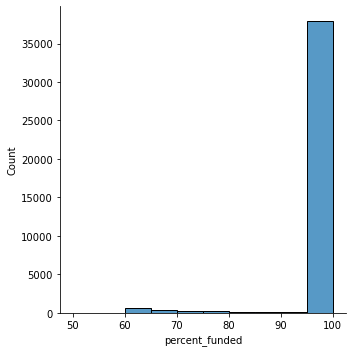

In [2]:
import seaborn as sns
sns.displot(data=loans,x="percent_funded",bins=range(50,105,5));

We create a binary classification problem by labelling whether each loan was at least 95% funded. The other columns will form the features for the predictions.

In [3]:
X = loans.drop("percent_funded",axis=1)
y = loans["percent_funded"] > 95

We will split into test and training sets and apply the nearest neighbors algorithm.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=0)

knn = KNeighborsClassifier(n_neighbors=5)   
knn.fit(X_tr,y_tr) 
acc = knn.score(X_te,y_te)
print(f"accuracy is {acc:.1%}")

accuracy is 94.8%


At first, this looks like a good result. But consider that the vast majority of loans were funded:

In [5]:
funded = sum(y)
print(f"{funded/len(y):.1%} were funded")

95.5% were funded


Therefore, an algorithm that simply "predicts" funding every loan could do even better than the trained classifier!

In [6]:
from sklearn import metrics
acc = metrics.accuracy_score(y_te,[True]*len(y_te))
print(f"fund-em-all accuracy is {acc:.1%}")

fund-em-all accuracy is 95.2%


In context, then, our trained classifier is not impressive at all. We need a metric other than accuracy to detect that.

## Binary classifiers

A binary classifier is one that produces just two unique labels, which we call "yes" and "no" here. To fully understand the performance of a binary classifier, we have to account for four cases:

* True positives (TP): Predicts "yes", actually is "yes"
* False positives (FP): Predicts "yes", actually is "no"
* True negatives (TN): Predicts "no", actually is "no"
* False negatives (FN): Predicts "no", actually is "yes"

The four cases correspond to a 2×2 table according to the states of the prediction and *ground truth*, which is the accepted correct value (i.e., the given label). The table can be filled with counts or percentages of tested instances, to create a **confusion matrix**, as illustrated in {numref}`fig-supervised-confusion`. 

```{figure} confusion.svg
---
name: fig-supervised-confusion
---
Confusion matrix
```

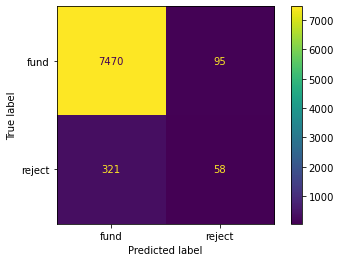

In [7]:
yhat = knn.predict(X_te)
C = metrics.confusion_matrix(y_te,yhat,labels=[True,False])
lbl = ["fund","reject"]
metrics.ConfusionMatrixDisplay(C,display_labels=lbl).plot();

Hence there are 7470 true positives (funded) and 58 true negatives (rejected). Therefore, the **accuracy** is 

$$
\text{accuracy} = \frac{\TP + \TN}{\TP + \FP + \TN + \FN} = \frac{7528}{7944} \approx 0.94763
$$

i.e., 94.8%. However, there are four other quantities defined by putting a "number correct" value in the numerator and the sum of a confusion matrix row or column in the denominator:

$$
\text{recall (aka sensitivity)} &= \frac{\TP}{\TP + \FN} \\[2mm]
\text{specificity} &= \frac{\TN}{\TN + \FP} \\[2mm] 
\text{precision} &= \frac{\TP}{\TP + \FP} \\[2mm] 
\text{negative predictive value (NPV)} &= \frac{\TN}{\TN + \FN} \\ 
$$

In words, these metrics answer the following questions:

* **recall** How often are actual "yes" cases predicted correctly?
* **specificity** How often are actual "no" cases predicted correctly?
* **precision** How often are the "yes" predictions correct?
* **NPV** How often are the "no" predictions correct?

For our loan classifier, here are the scores:

In [8]:
TP,FN,FP,TN = C.ravel()
print(f"recall = {TP/(TP+FN):.1%}")
print(f"specificity = {TN/(TN+FP):.1%}")
print(f"precision = {TP/(TP+FP):.1%}")
print(f"NPV = {TN/(TN+FN):.1%}")

recall = 98.7%
specificity = 15.3%
precision = 95.9%
NPV = 37.9%


The high recall rate means that few who ought to get a loan will go away disappointed. However, the low specificity would be concerning to those doing the funding, because almost 85% of those who should be rejected will be funded as well. 

There are numerous ways to combine these measures into a single number other than standard accuracy. None is universally best, because different applications emphasize different aspects of performance. One of the most popular is the ***F*₁ score**, which is the harmonic mean of the precision and the recall:

$$
F_1 = \left[ \frac{1}{2} \left(\frac{\TP + \FN}{\TP} + \frac{\TP+\FP}{\TP} \right)  \right]^{-1} = \frac{2\TP}{2\TP+\FN+\FP}.
$$

This score varies between zero (poor) and one (ideal). You may know the harmonic mean as the operation for wiring electrical resistors in parallel. If one of the quantities is much smaller than the other, their harmonic mean will be close to the small value. Thus, *F*₁ score punishes a classifier if either recall or precision is poor. 

In `sklearn.metrics` there are functions to compute all the above scores, except for NPV, without reference to the confusion matrix. You must put the ground truth labels before the predicted labels, and you should also specify which of the labels in the label vector corresponds to a "positive" result. Swapping the "positive" role also swaps recall with specificity, and precision with NPV.

In [9]:
print("recall with True as positive:",metrics.recall_score(y_te,yhat,pos_label=True))

# Compute recall using False as the "positive" label
print("recall with False as positive:",metrics.recall_score(y_te,yhat,pos_label=False))

recall with True as positive: 0.9874421678783873
recall with False as positive: 0.15303430079155672


Another composite score is **balanced accuracy**, which is the mean of recall and specificity. It also ranges from 0 to 1, with 1 meaning perfect accuracy.

In [10]:
print("F1:",metrics.f1_score(y_te,yhat))
print("Balanced:",metrics.balanced_accuracy_score(y_te,yhat))

F1: 0.9729096118780932
Balanced: 0.570238234334972


The loan classifier trained above has excellent recall, respectable precision, and terrible specificity, resulting in a good *F*₁ score and a low balanced accuracy score.

```{prf:example}
Inspired by the high funding rate, suppose we try a "classifier" that funds every loan. Then 

$$
\TP = k,\, \TN = 0,\, \FP = n-k,\, \FN = 0.
$$

Its *F*₁ score is thus

$$
\frac{2\TP}{2\TP+\FN+\FP} = \frac{2k}{2k+n-k} = \frac{2k}{k+n},
$$

and its balanced accuracy is 

$$
\frac{1}{2} \left(\frac{\TP}{\TP+\FN} + \frac{\TN}{\TN+\FP} \right)  = \frac{1}{2}.
$$

If the fraction of funded samples in the test set is $k/n=a$, then the *F*₁ score is $a/(1+a)$, which increases smoothly from zero to one as $a$ does. For the loan problem, $a=0.816$ and the *F*₁ of this lazy classifier is $0.449$. 
```

<!-- 
print("F1:",metrics.cohen_kappa_score(y_te,yhat))
print("F1:",metrics.matthews_corrcoef(y_te,yhat)) -->

The point is that each individual metric gives part of the picture, and selecting the right one depends on what traits the application values most.

## Multiclass classifiers

When there are more than two unique possible labels, these metrics can be applied using the **one-vs-rest** paradigm. For $K$ unique labels, this paradigm poses $K$ binary questions: "Is it in class 1, or not?", "Is it in class 2, or not?", etc. This produces $K$ versions of metrics such as accuracy, recall, *F*₁ score, and so on, which can be averaged to give a single score. There are various ways to perform the averaging, depending on whether poorly represented classes are to be weighted more weakly than others. We won't give the details.

The confusion matrix also generalizes to $K$ classes. It's easiest to see how by an example. We will load a dataset on the characteristics of cars and use quantitative factors to predict the region of origin.

392 samples, 5 features


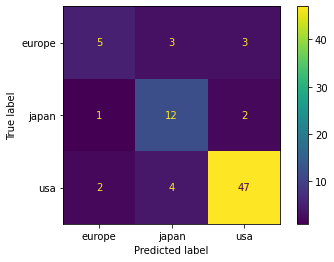

In [11]:
cars = sns.load_dataset("mpg").dropna()
X = cars[["cylinders","horsepower","weight","acceleration","mpg"]]
y = pd.Categorical(cars["origin"])

X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=1)
print(X.shape[0],"samples,",X.shape[1],"features")

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X,y)
yhat = knn.predict(X_te)

labels = y.categories
C = metrics.confusion_matrix(y_te,yhat,labels=labels)
metrics.ConfusionMatrixDisplay(C,display_labels=labels).plot();

From the confusion matrix, we can see that, for example, out of 52 predictions of "usa" on the test set, there are 5 total false positives. Therefore, that precision is $47/52=90.4$%. We can get all the individual precision scores automatically.

In [12]:
prec = metrics.precision_score(y_te,yhat,average=None)
for (i,p) in enumerate(prec): print(f"{labels[i]}: {p:.1%}")

europe: 62.5%
japan: 63.2%
usa: 90.4%


To get a composite precision score, we have to specify an averaging method. The `"macro"` option simply takes the mean of the vector above.

In [13]:
mac = metrics.precision_score(y_te,yhat,average="macro")
print(mac)

0.7201417004048584
